In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shap datasets transformers

In [ ]:
import transformers
import torch


def get_model_and_tokenizer(
        model_type, model_name, tokenizer_name, num_classes, state_dict
):
    model_class = getattr(transformers, model_name)
    model = model_class.from_pretrained(
        pretrained_model_name_or_path=None,
        config=model_type,
        num_labels=num_classes,
        state_dict=state_dict,
    )
    tokenizer = getattr(transformers, "BertTokenizerFast").from_pretrained(model_type)

    return model, tokenizer


def load_binary_bert():
    state_dict = torch.hub.load_state_dict_from_url(
        "https://github.com/unitaryai/detoxify/releases/download/v0.1-alpha/toxic_original-c1212f89.ckpt")

    class_names = state_dict["config"]["dataset"]["args"]["classes"]

    model, tokenizer = get_model_and_tokenizer(
        **state_dict["config"]["arch"]["args"], state_dict=state_dict["state_dict"]
    )

    return model, tokenizer, class_names


In [ ]:
from operator import itemgetter

def f1(predictions, gold):
    """
    F1 (a.k.a. DICE) operating on two lists of offsets (e.g., character).
    >>> assert f1([0, 1, 4, 5], [0, 1, 6]) == 0.5714285714285714
    :param predictions: a list of predicted offsets
    :param gold: a list of offsets serving as the ground truth
    :return: a score between 0 and 1
    """
    if len(gold) == 0:
        return 1 if len(predictions) == 0 else 0
    nom = 2 * len(set(predictions).intersection(set(gold)))
    denom = len(set(predictions)) + len(set(gold))
    return nom / denom

def preds_to_spans(preds, threshold=0.2, cumulative=False):
    attention, spans = preds
    pred_spans = []
    if cumulative:
        cumulated_attention = 0
        sorted_idx_attention = np.argsort(attention)[::-1]
        for idx in sorted_idx_attention:
            if spans[idx] is not None:
                i, j = spans[idx]
                pred_spans.extend(range(i, j))
                cumulated_attention += attention[idx]

            if cumulated_attention >= threshold:
                break
    else:
        for attn, span in zip(attention, spans):
            if attn > threshold and span is not None:
                i, j = span
                pred_spans.extend(range(i, j))

    return pred_spans

In [ ]:
import numpy as np
import scipy as sp
import shap
import torch
from datasets import load_dataset

model, tokenizer, class_names = load_binary_bert()

explain = ['Only an idiot would use and believe anything this This Republican propaganda machine publishes: www.realclearpolitics.com',
           'You are a fucking moron, I hope you will die, please uninstall this shitty game, have a nice day, it was pleasure to play with you']

model.cuda()
def f(x):
    input = torch.tensor([tokenizer.encode(v, padding='longest', max_length=500, truncation=True) for v in x]).cuda()
    scores = torch.sigmoid(model(input)[0]).cpu().detach().numpy()
    return scores[:, 0]


explainer = shap.Explainer(f, tokenizer)
shap_values = explainer(explain, max_evals=1000) # default chyba 200 jest albo 100 i wtedy ze względu na to jak to działa te shapley values liczą się dla dłuższych fraz, 
#potencjalnie parametr którym chcemy sterować, ale raczej tak jak teraz jest git

shap.plots.text(shap_values)

explainers.Partition is still in an alpha state, so use with caution...


### Thresholds

In [ ]:
import pandas as pd
from ast import literal_eval

dataset = pd.read_csv("/content/drive/MyDrive/gsn/tsd_trial.csv")
dataset.loc[:, 'spans'] = dataset['spans'].apply(literal_eval)
dataset.head()

,spans,text
0,"[15, 16, 17, 18, 19, 27, 28, 29, 30, 31]",Because he's a moron and a bigot. It's not any...
1,"[29, 30, 31, 32, 33, 34]",How about we stop protecting idiots and let na...
2,"[166, 167, 168, 169, 170, 171]","If people were smart, they would Boycott th..."
3,"[87, 88, 89, 90, 91, 92]",Trump Claimed that Russia will never invade th...
4,[],As long as your willing to pay a lot more for ...


In [ ]:
x = explainer(dataset['text'], max_evals=2000)

In [ ]:
offsets = [tokenizer(v, padding='longest', max_length=500, truncation=True, return_offsets_mapping=True)['offset_mapping'] for v in dataset['text']]

In [ ]:
type(dataset['spans'][0])

In [ ]:
import plotly.express as px
from collections import defaultdict

data = defaultdict(list)
for threshold in np.linspace(0, 1, 100):
    scores = defaultdict(list)
    for shapvals, offsets_, label in zip(x.values, offsets, dataset['spans']):
        scaled_values = shapvals/np.sum(shapvals)
        pred_scaled = (scaled_values, offsets_)

        predicted_spans = preds_to_spans(pred_scaled, threshold=threshold, cumulative=True)
        scores['cumulative_scaled'].append(f1(predicted_spans, label))
        predicted_spans = preds_to_spans(pred_scaled, threshold=threshold, cumulative=False)
        scores['value_scaled'].append(f1(predicted_spans, label))

        pred_not_scaled = (shapvals, offsets_)
        predicted_spans = preds_to_spans(pred_not_scaled, threshold=threshold, cumulative=True)
        scores['cumulative_raw'].append(f1(predicted_spans, label))
        predicted_spans = preds_to_spans(pred_not_scaled, threshold=threshold, cumulative=False)
        scores['value_raw'].append(f1(predicted_spans, label))

    data['threshold'].append(threshold)
    data['cumulative_scaled'].append(np.mean(np.array(scores['cumulative_scaled'])))
    data['value_scaled'].append(np.mean(np.array(scores['value_scaled'])))
    data['cumulative_raw'].append(np.mean(np.array(scores['cumulative_raw'])))
    data['value_raw'].append(np.mean(np.array(scores['value_raw'])))

In [ ]:
df = pd.DataFrame(data)
df.head()

,threshold,cumulative_scaled,value_scaled,cumulative_raw,value_raw
0,0.000000,0.488724,0.324387,0.503561,0.333647
1,0.010101,0.488724,0.433237,0.504774,0.480929
2,0.020202,0.488724,0.481811,0.502290,0.524241
3,0.030303,0.488724,0.510160,0.506791,0.541297
4,0.040404,0.488724,0.527365,0.505504,0.550445


In [ ]:
df = df.set_index('threshold')
df.head()

In [ ]:
df.to_csv('/content/drive/MyDrive/gsn/plot_thresholds_2000.csv')

In [ ]:
import seaborn as sns

sns.set_style('whitegrid')
sns.set_context('paper')
sns.set(rc={'figure.figsize':(20, 15)})

%matplotlib inline
g = sns.scatterplot(data=df)
g.get_figure().savefig('plot.png')

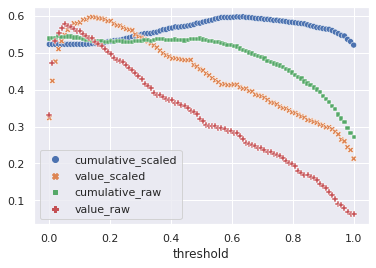

In [ ]:
g = sns.scatterplot(data=df)
g.get_figure().savefig('plot.png')

In [ ]:
df.idxmax()

cumulative_scaled    0.636364
value_scaled         0.141414
cumulative_raw       0.030303
value_raw            0.050505
dtype: float64

In [ ]:
df.max()

cumulative_scaled    0.596823
value_scaled         0.596470
cumulative_raw       0.543750
value_raw            0.577837
dtype: float64

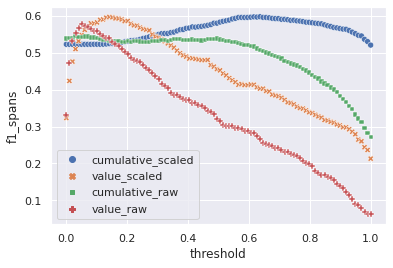

In [ ]:
g = sns.scatterplot(data=df)
g.set(ylabel='f1_spans')
g.get_figure().savefig('plot2.png')

### Predict - Test

In [ ]:
def split_sentence(tokenizer, text, spans=None, max_sentence_length=500):
    encoded = tokenizer(text, add_special_tokens=True, return_offsets_mapping=True)
    sentences_offsets = [offset[1] for input_ids, offset in zip(encoded['input_ids'], encoded['offset_mapping'])
                         if input_ids == 1012]
    if len(sentences_offsets) == 0 or len(text) - sentences_offsets[-1] > 0:
        sentences_offsets.append(len(text))

    new_split = [0]
    for split_offset_id in range(len(sentences_offsets) - 1):
        if sentences_offsets[split_offset_id + 1] - new_split[-1] > max_sentence_length:
            new_split.append(sentences_offsets[split_offset_id])

    if not new_split[-1] == sentences_offsets[-1]:
        new_split.append(sentences_offsets[-1])

    if spans:
        spans_vector = [i in row['spans'] for i in range(len(row['text']))]

    texts, new_spans, offsets = [], [], []
    for offset_id in range(len(new_split) - 1):
        a, b = new_split[offset_id], new_split[offset_id + 1]
        texts.append(text[a:b])
        offsets.append(new_split[offset_id])

        if spans:
            spans_in_subtext = [idx for idx, is_true in enumerate(spans_vector[a:b]) if is_true]
            new_spans.append(spans_in_subtext)

    if not spans:
        new_spans = [[] for _ in range(len(offsets))]

    return texts, offsets, new_spans

In [ ]:
import csv

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

df = pd.read_csv("/content/drive/MyDrive/gsn/tsd_test.csv")
result = pd.DataFrame({'spans': pd.Series(np.zeros(len(df))).values})

for i, row in tqdm(df.iterrows(), total=len(df)):
    texts, sentence_offsets, _ = split_sentence(tokenizer, row['text'], max_sentence_length=500)

    predicted_spans = list()
    for text, sentence_offset in zip(texts, sentence_offsets):
        x = explainer([text], max_evals=2000)
        offsets_ = tokenizer(text, padding='longest', max_length=500, truncation=True, return_offsets_mapping=True)['offset_mapping']
        preds = (x.values[0]/np.sum(x.values[0]), offsets_)
        spans = preds_to_spans(preds, threshold=0.636364, cumulative=True)
        predicted_spans.extend(list(np.array(spans) + sentence_offset))

    result.loc[i, 'spans'] = str(predicted_spans)
print(result.head())
result.to_csv('spans-pred.txt', header=False, sep='\t', quoting=csv.QUOTE_NONE, escapechar='\n')


In [ ]:
result.to_csv('spans-pred.txt', header=False, sep='\t', quoting=csv.QUOTE_NONE, escapechar='\n')

In [ ]:
result.to_csv('/content/drive/MyDrive/spans-pred.txt', header=False, sep='\t', quoting=csv.QUOTE_NONE, escapechar='\n')

In [ ]:
print(result.head())

                                               spans
0  [140, 141, 142, 143, 144, 145, 146, 136, 137, ...
1                           [81, 82, 83, 84, 85, 86]
2  [471, 472, 473, 474, 475, 476, 477, 467, 468, ...
3  [225, 226, 227, 228, 229, 230, 231, 232, 4, 5,...
4  [0, 1, 2, 3, 4, 231, 6, 7, 8, 9, 10, 11, 12, 1...
